In [1]:
import numpy as np
import torch

import sys
sys.path.append("../")

from src.models.VGAE import VGAE
from src.datasets.utils import normalize_adjacency, remove_self_loops
from src.plot import plot_dynamic_graph

In [2]:
data_path = "../data/data.npz"
num_samples = 20

hidden_dim = 256
latent_dim = 256 

batch_size = 5
num_epochs = 100
learning_rate = 1e-3

In [3]:
data_dic = dict(np.load(data_path, allow_pickle=True).items())
dataset = torch.utils.data.TensorDataset(torch.from_numpy(data_dic["X"]).float(), torch.from_numpy(data_dic["A"]).float())
node_dim = dataset.tensors[0].shape[-1]
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
model = VGAE(node_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
elbo_results = []
nll_results = []
kl_results = []

model.train()

for epoch in range(num_epochs):

    epoch_elbo = 0
    epoch_nll = 0
    epoch_kl = 0

    for X, A in dataloader:

        # B x T x N x D -> TB x N x D
        X = X.reshape(-1, *X.shape[2:]) 
        # B x T x N x N -> BT x N x N
        A = A.reshape(-1, *A.shape[2:]) 
        A_norm = normalize_adjacency(A)
        A_norm = remove_self_loops(A_norm)

        optimizer.zero_grad()
        A_recon, Z_posterior = model.forward(X, A_norm)
        elbo, nll, kl = model.loss(A_recon, A, Z_posterior)
        elbo.backward()
        optimizer.step()

        epoch_elbo += elbo.item() / len(dataloader)
        epoch_nll += nll.item() / len(dataloader)
        epoch_kl += kl.item() / num_samples

    elbo_results += [epoch_elbo]
    nll_results += [epoch_nll]
    kl_results += [epoch_kl]

    if epoch % 10 == 0:
        print("epoch {:4d} | elbo {:6.2f} | nll {:6.2f} | kl {:6.2f}".format(epoch, elbo_results[-1], nll_results[-1], kl_results[-1]))

epoch    0 | elbo   2.74 | nll   1.50 | kl   0.25
epoch   10 | elbo   2.73 | nll   1.50 | kl   0.25
epoch   20 | elbo   2.73 | nll   1.50 | kl   0.25
epoch   30 | elbo   2.73 | nll   1.49 | kl   0.25
epoch   40 | elbo   2.72 | nll   1.50 | kl   0.25
epoch   50 | elbo   2.73 | nll   1.50 | kl   0.25
epoch   60 | elbo   2.72 | nll   1.49 | kl   0.25
epoch   70 | elbo   2.72 | nll   1.49 | kl   0.25
epoch   80 | elbo   2.72 | nll   1.49 | kl   0.25
epoch   90 | elbo   2.72 | nll   1.50 | kl   0.24


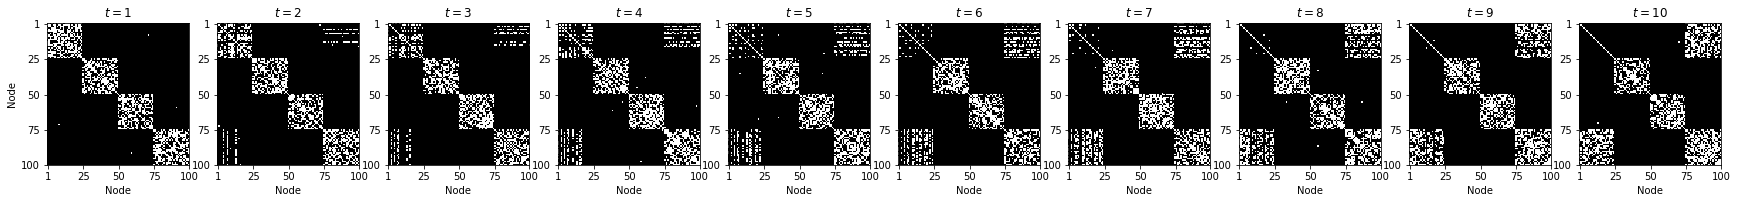

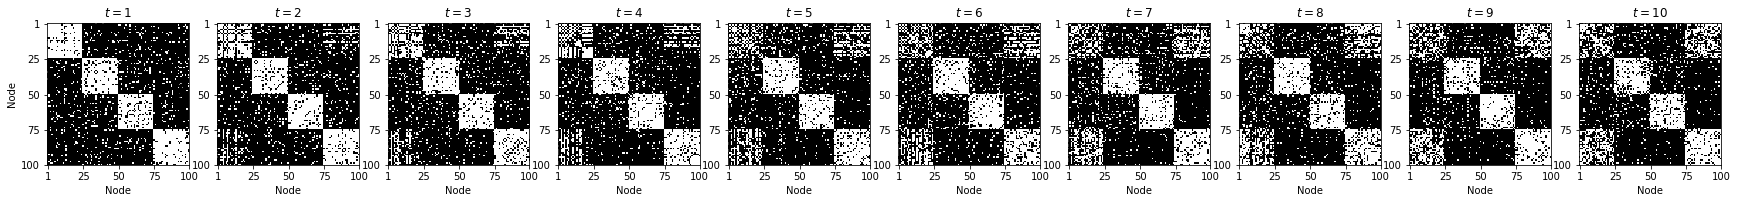

In [6]:
_A = A.reshape(batch_size, -1, node_dim, node_dim).detach()
_A_recon = A_recon.reshape(batch_size, -1, node_dim, node_dim).detach()
plot_dynamic_graph(_A[0].numpy())
plot_dynamic_graph(_A_recon[0].sigmoid().numpy() > 0.9)